In [1]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import silhouette_score, davies_bouldin_score, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.metrics import mean_squared_error,  accuracy_score, f1_score, average_precision_score, precision_score, recall_score, balanced_accuracy_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

In [2]:
def train_and_plot_results(X, Y, model, class_weight = None, penalty = 'l2', C = 1, pca_dimension = None, n_estimators = 20, max_depth = 23 ):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 10)
    if pca_dimension != None:
        h = pca_dimension
        pca = PCA(n_components = h)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
    
    if model == LogisticRegression:
        clf_log = model(penalty= penalty , C=C, class_weight = class_weight).fit(X_train, y_train) #solver='lbfgs'
        if pca_dimension != None:
            print('PCA dimension: ', pca_dimension)
        print("Parameters of Logistic Regression: ", clf_log.get_params)
    
    if model == RandomForestClassifier:
        clf_log = model(n_estimators = n_estimators, max_depth = max_depth, class_weight = class_weight)
        clf_log.fit(X_train, y_train)
        print("Parameters of Random Forest: ", clf_log.get_params)
        
        
    y_pred=clf_log.predict_proba(X_test)
    fpr,tpr,_=roc_curve(y_test,y_pred[:,1])
    area=auc(fpr,tpr)
    fig=plt.figure()
    lw = 2
    plt.plot(fpr,tpr,color="darkred", lw=lw, label="ROC curve RF : AUC = {:.3f}".format(area))
    plt.plot([0,1], [0,1], color="navy", lw=lw, linestyle="--")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic curve")
    plt.legend(loc="lower right")
    
    y_pred_binary = clf_log.predict(X_test)
    
    fig=plt.figure()
    
    CM=confusion_matrix(y_test, y_pred_binary)
    sns.heatmap(CM, annot=True)
    

    err_train = sum(abs(clf_log.predict(X_train) - y_train))/len(y_train)
    err_test = sum(abs(clf_log.predict(X_test) -  y_test))/len(y_test)



    recall = CM[1,1]/(CM[1,0]+CM[1,1]) # tp/(tp+fn)
    precision = CM[1,1]/(CM[0,1]+CM[1,1]) # # tp/(tp+fp)
    tnr = CM[0,0]/(CM[0,1]+CM[0,0]) # tn/(tn+fp) Acc-
    tpr = recall # Acc+

    f_measure = 2*precision*recall/(precision+recall)
    g_mean = (tpr*tnr) ** 0.5
    weighted_accuracy = 0.5 * tnr + 0.5 * tpr
    
    print('')
    print('Metris: ')
    print('True Negative Rate (Acc-): {:.2f}%'.format(100*tnr))
    print('True Positive Rate (Acc+): {:.2f}%'.format(100*tpr))
    print('G-Mean: {:.2f}%'.format(100*g_mean))
    print('Weighted Accuracy: {:.2f}%'.format(100*weighted_accuracy))
    print('Precision: {:.2f}%'.format(100*precision))
    print('Recall: {:.2f}%'.format(100*recall))
    print('F-measure: {:.2f}%'.format(100*f_measure))

    print('Training error {:.2f}% and the test error is {:.2f}%'.format(err_train*100, 
                                                                             err_test*100))
    
    return clf_log, clf_log.get_params, [fpr,tpr] , [f_measure, g_mean , weighted_accuracy]

In [3]:
def plot_results(y_test, y_pred_binary):
    fig=plt.figure()
    CM=confusion_matrix(y_test, y_pred_binary)
    sns.heatmap(CM, annot=True)
    

    err_test = sum(abs(y_pred_binary -  y_test))/len(y_test)



    recall = CM[1,1]/(CM[1,0]+CM[1,1]) # tp/(tp+fn)
    precision = CM[1,1]/(CM[0,1]+CM[1,1]) # # tp/(tp+fp)
    tnr = CM[0,0]/(CM[0,1]+CM[0,0]) # tn/(tn+fp) Acc-
    tpr = recall # Acc+

    f_measure = 2*precision*recall/(precision+recall)
    g_mean = (tpr*tnr) ** 0.5
    weighted_accuracy = 0.5 * tnr + 0.5 * tpr
    
    print('')
    print('Metris: ')
    print('True Negative Rate (Acc-): {:.2f}%'.format(100*tnr))
    print('True Positive Rate (Acc+): {:.2f}%'.format(100*tpr))
    print('G-Mean: {:.2f}%'.format(100*g_mean))
    print('Weighted Accuracy: {:.2f}%'.format(100*weighted_accuracy))
    print('Precision: {:.2f}%'.format(100*precision))
    print('Recall: {:.2f}%'.format(100*recall))
    print('F-measure: {:.2f}%'.format(100*f_measure))

    print('Test error is {:.2f}%'.format(err_test*100))

# For the full database (biased):

In [4]:
data = pd.read_csv('./Data/encoded_data_all.csv')
del data['Unnamed: 0'] #this is a problem with the index that came duplicated

features = list(data.columns)
features.remove('no_show') #this removes the output (no show) from the training variables

Y = data['no_show']
X = data[features]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 10) # shuffle train and test data

In [5]:
models_comparison = {}
models_comparison['model'] = []
models_comparison['param'] = []
models_comparison['roc'] = []
models_comparison['metric'] = []

#### Let's begin with a logistic regression with equal penalisation for false positives and false negatives, without PCA and without Lasso/Ridge

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Parameters of Logistic Regression:  <bound method BaseEstimator.get_params of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)>

Metris: 
True Negative Rate (Acc-): 99.93%
True Positive Rate (Acc+): 0.53%
G-Mean: 7.26%
Weighted Accuracy: 50.23%
Precision: 37.15%
Recall: 0.53%
F-measure: 1.04%
Training error 7.04% and the test error is 7.05%


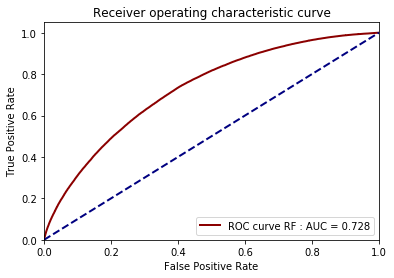

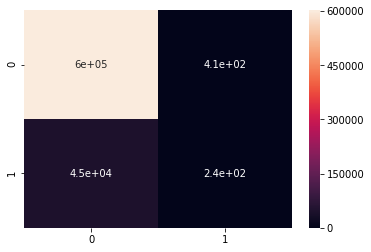

In [6]:
model1, params1, roc1, metrics1 =  train_and_plot_results(X, Y, model = LogisticRegression)

## We notice that the Logistic Regression just attributes almost everyone as negative samples (no_show = 0). This gives a small test error (7,09 %) because the data is unbalanced (7% of positive samples). The algorithm is not good at all.

### Let's apply a PCA to reduce dimension

#### Let's have an idea of how many dimensions do we need to explain most of the data variance

In [7]:
#For 3 dimensions
h = 3
pca = PCA(n_components = h)
pca.fit(X_train)
X_train_pca_h = pca.transform(X_train)
print("Total ratio of explained variance of the data in this new space:", np.sum(pca.explained_variance_ratio_))

Total ratio of explained variance of the data in this new space: 0.9818622397072251


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


PCA dimension:  3
Parameters of Logistic Regression:  <bound method BaseEstimator.get_params of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)>

Metris: 
True Negative Rate (Acc-): 100.00%
True Positive Rate (Acc+): 0.00%
G-Mean: 0.00%
Weighted Accuracy: 50.00%
Precision: nan%
Recall: 0.00%
F-measure: nan%
Training error 7.02% and the test error is 7.02%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in longlong_scalars


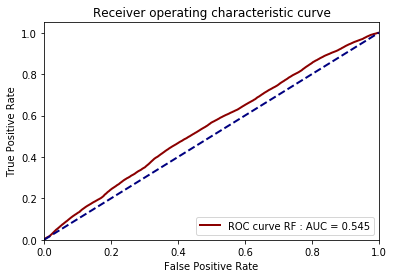

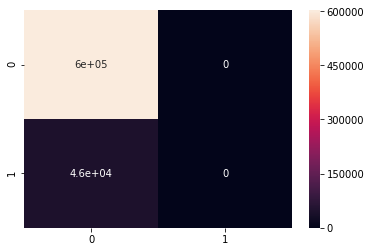

In [8]:
model2, params2, roc2, metrics2 =  train_and_plot_results(X, Y, model = LogisticRegression, pca_dimension=3)

### If we reduce the dimensions to 3 with the PCA, the model is literally guessing that everyone will show up, which  is terrible. Let's increase the dimension to 70 (out of 88)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


PCA dimension:  70
Parameters of Logistic Regression:  <bound method BaseEstimator.get_params of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)>

Metris: 
True Negative Rate (Acc-): 99.93%
True Positive Rate (Acc+): 0.53%
G-Mean: 7.25%
Weighted Accuracy: 50.23%
Precision: 37.05%
Recall: 0.53%
F-measure: 1.04%
Training error 7.04% and the test error is 7.05%


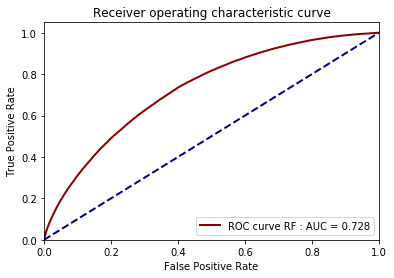

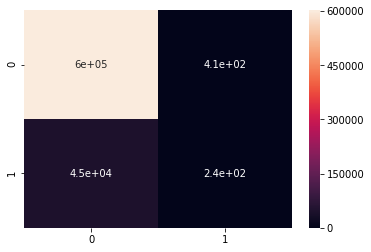

In [9]:
model3, params3, roc3, metrics3 =  train_and_plot_results(X, Y, model = LogisticRegression, pca_dimension=70)

## Increasing the dimension doesn't help a lot. Let's try to add a L1 penalisation

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Parameters of Logistic Regression:  <bound method BaseEstimator.get_params of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)>

Metris: 
True Negative Rate (Acc-): 99.93%
True Positive Rate (Acc+): 0.53%
G-Mean: 7.25%
Weighted Accuracy: 50.23%
Precision: 37.05%
Recall: 0.53%
F-measure: 1.04%
Training error 7.04% and the test error is 7.05%


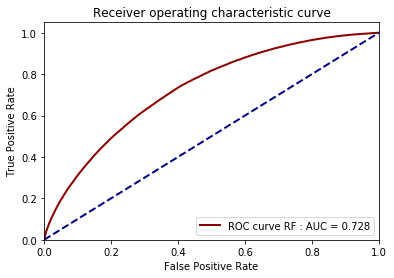

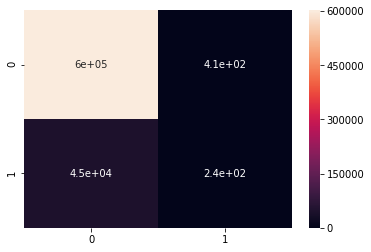

In [10]:
model4, params4, roc4, metrics4  =  train_and_plot_results(X, Y,model = LogisticRegression, penalty='l1')

### Still bad. Let's add a gridSearch to look for the best parameter of the penalisation

# Let's add class_weight = 'balanced' as a parameter to logistic regression. It'll change the weight of the false positive error and false negative accordingly to the proportion of each class in the data

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Parameters of Logistic Regression:  <bound method BaseEstimator.get_params of LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)>

Metris: 
True Negative Rate (Acc-): 64.96%
True Positive Rate (Acc+): 68.23%
G-Mean: 66.57%
Weighted Accuracy: 66.59%
Precision: 12.82%
Recall: 68.23%
F-measure: 21.59%
Training error 34.73% and the test error is 34.81%


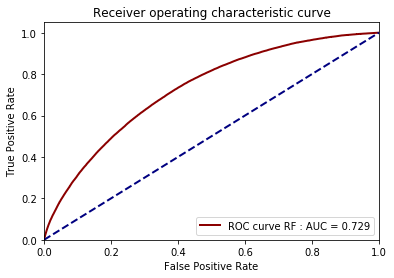

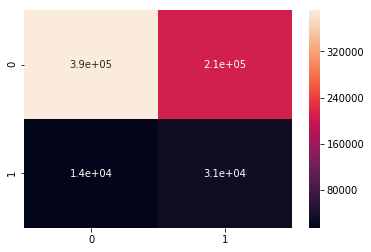

In [11]:
model5, params5, roc5, metrics5  =  train_and_plot_results(X, Y, model = LogisticRegression, class_weight = 'balanced' )

# Now we have about the same True positive rate and true negative rate. In exchange, we have increased our error from about 7% to 34,8% (This increases our weighted accuracy from 50% to 66,97%)

# Let's now use a RandomForest model

Parameters of Random Forest:  <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

Metris: 
True Negative Rate (Acc-): 99.99%
True Positive Rate (Acc+): 0.17%
G-Mean: 4.11%
Weighted Accuracy: 50.08%
Precision: 58.33%
Recall: 0.17%
F-measure: 0.34%
Training error 6.98% and the test error is 7.02%


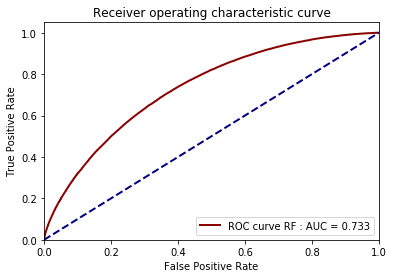

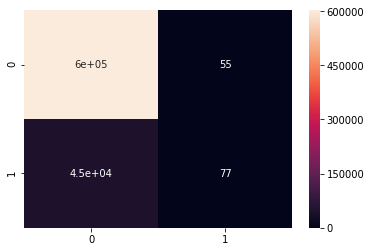

In [12]:
model6, params6, roc6, metrics6 = train_and_plot_results(X, Y, model = RandomForestClassifier, n_estimators = 13, max_depth = 15 , class_weight = None)

### We notice the same problem as for the simplest logistic regression. Let's add class_weight = 'balanced'.

Parameters of Random Forest:  <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=6, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)>

Metris: 
True Negative Rate (Acc-): 66.48%
True Positive Rate (Acc+): 64.98%
G-Mean: 65.73%
Weighted Accuracy: 65.73%
Precision: 12.77%
Recall: 64.98%
F-measure: 21.35%
Training error 33.60% and the test error is 33.62%


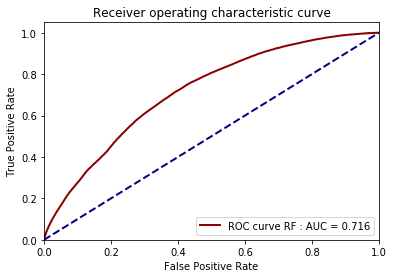

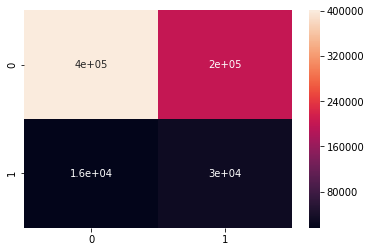

In [13]:
model7, params7, roc7, metrics7 = train_and_plot_results(X, Y, model = RandomForestClassifier, n_estimators = 50, max_depth = 6 , class_weight = 'balanced')

### As in the case of the logistic regression, we exchange test error by g-Mean and Weighted Accuracy

# CONCLUSION: The result using the whole data is almost the same as the result using only 5% of the data: The best model obtained for the logistic regression is very simillar to the best one obtained for Random Forest

In [35]:
metrics_list = [metrics1, metrics2, metrics3, metrics4, metrics5, metrics6, metrics7]

weighted_accuracy_list = [metric[2] for metric in metrics_list]
g_mean_list = [metric[1] for metric in metrics_list]
f1_list = [metric[0] for metric in metrics_list]



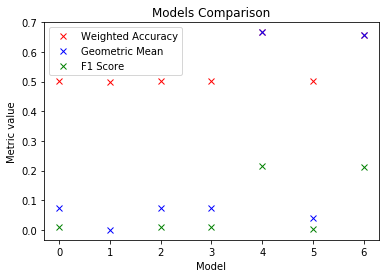

In [36]:
fig, axes = plt.subplots()
axes.plot( weighted_accuracy_list, 'xr', label = "Weighted Accuracy")
axes.set_xlabel('Model')
axes.set_ylabel('Metric value')
axes.set_title('Models Comparison');

axes.plot(g_mean_list, 'xb' , label="Geometric Mean")
axes.plot(f1_list, 'xg' , label="F1 Score")

axes.legend()


In [37]:
fig.savefig("Models_Comparison.png")